In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Wed Jan 28 06:51:41 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   32C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, Resized, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['PV', 'DEL','SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['PV', 'DEL', 'SEGM'], spatial_size=PATCH_SIZE, padding_mode=('reflection', 'reflection','reflection'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['PV', 'DEL', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['PV', 'DEL', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['PV', 'DEL', 'SEGM'])
])

val_transforms = Compose([
    LoadImaged(keys=['PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection', 'reflection','reflection')),
    #Resized(keys=['PV', 'DEL', 'DEL', 'LIVER_SEGM'], spatial_size=PATCH_SIZE),
    ScaleIntensityRangePercentilesd(keys=['PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PV', 'DEL', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['PV', 'DEL', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PV', 'DEL', 'SEGM']),
    Orientationd(keys=['PV', 'DEL', 'SEGM'], axcodes='RAS'),
    Spacingd(keys=['PV', 'DEL', 'SEGM'], pixdim=SPACING, mode=('bilinear','bilinear', 'nearest'), padding_mode=('reflection','reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['PV', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PV', 'DEL', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['PV', 'DEL'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['PV', 'DEL']),
    Orientationd(keys=['PV', 'DEL'], axcodes='RAS'),
    Spacingd(keys=['PV', 'DEL'], pixdim=SPACING, mode=('bilinear','bilinear'), padding_mode=('reflection', 'reflection')),
    ScaleIntensityRangePercentilesd(keys=['PV', 'DEL', 'DEL'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], ARTfix=('val_image','val_segm')),
    ToTensord(keys=['PV', 'DEL'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-DEL-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.Dataset(
    data=test_data_dict, transform=test_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([20, 1, 64, 64, 32])
torch.Size([20, 1, 64, 64, 32])
PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: -0.3223215937614441
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: -0.32072195410728455


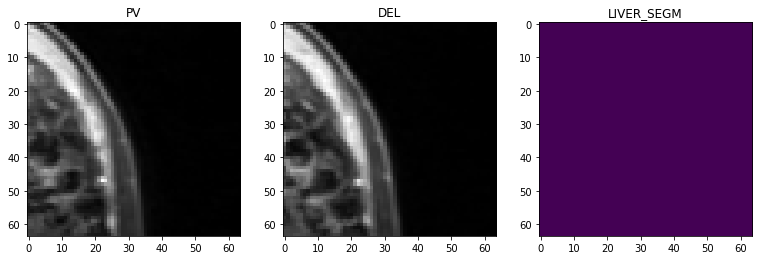

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5017319321632385
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.48584994673728943


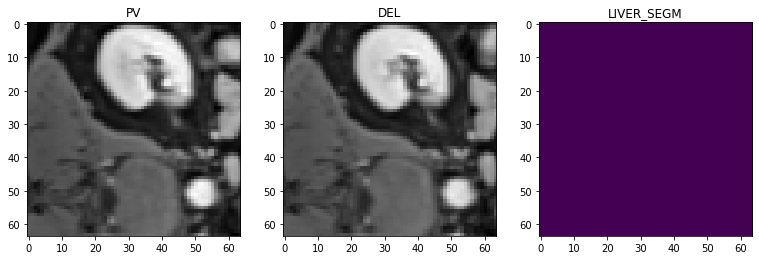

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5288232564926147
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.4711673855781555


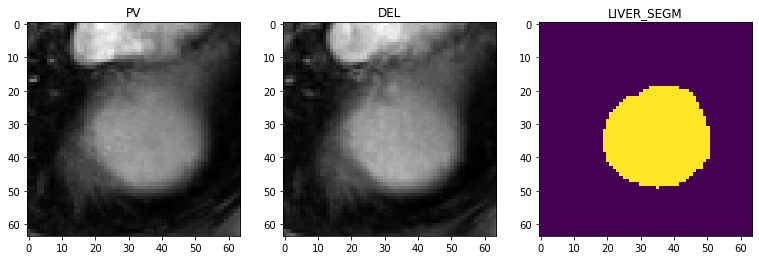

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: -0.02992115542292595
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: -0.04284239560365677


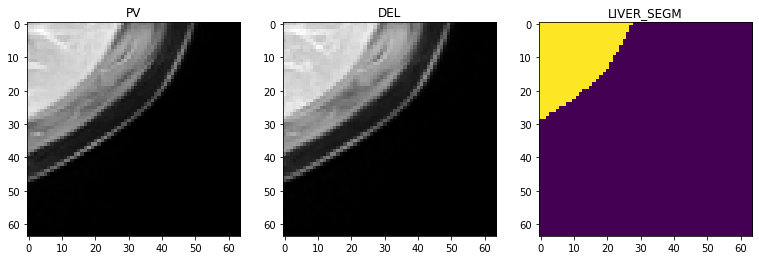

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.8187274932861328
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.7643664479255676


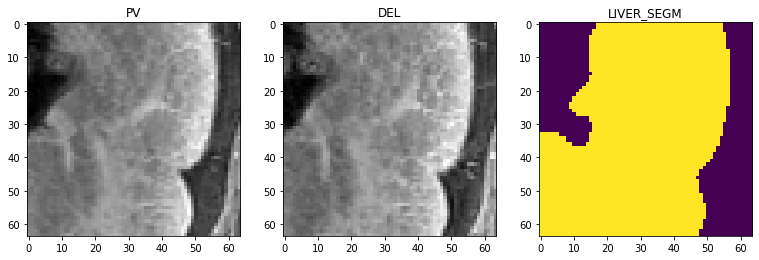

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.4070916473865509
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.33763301372528076


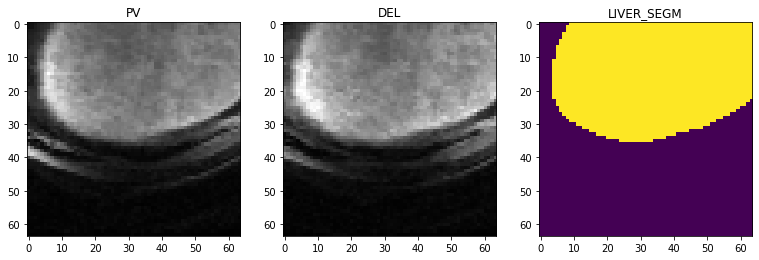

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.1144373416900635
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.9142574667930603


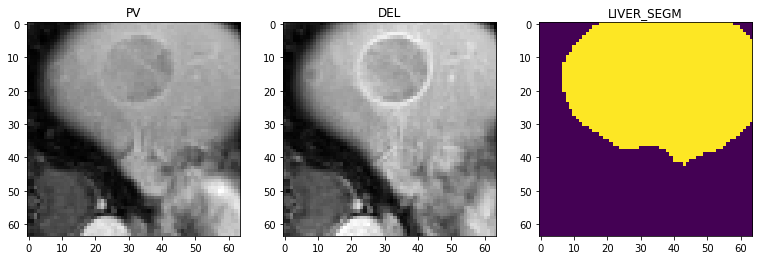

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.5448557138442993
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.44015252590179443


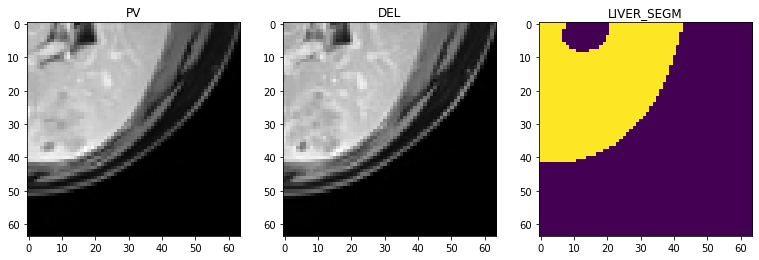

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 1.0758415460586548
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.9681416153907776


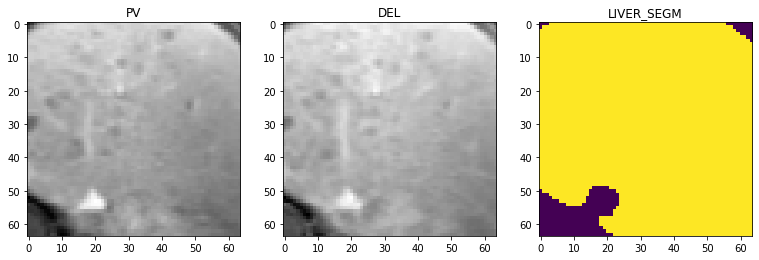

PV shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
PV mean: 0.8962754011154175
DEL shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
DEL mean: 0.8385701179504395


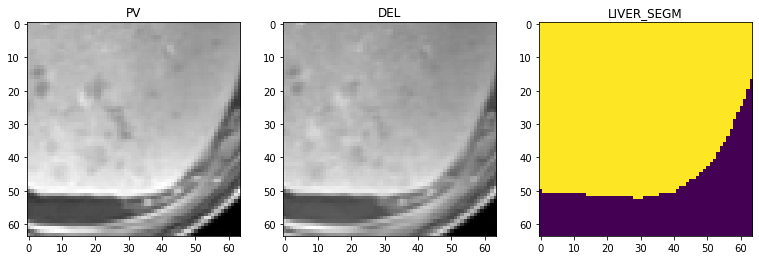

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[10:11], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)


num_display = 10
if check_data['PV'].shape[0] < num_display:
    num_display = check_data['PV'].shape[0]

for i in range(num_display):
    PV, DEL, liver_label = (check_data['PV'][i][0],check_data['DEL'][i][0], check_data['SEGM'][i][0])


    
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))
    
    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    
    slice_num = PV.shape[2]//2
    
    plt.figure('check', (13, 15))

    plt.subplot(1, 3, 1)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')

 
    
    plt.subplot(1, 3, 2)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')

    plt.subplot(1, 3 ,3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    
    plt.show()



    


## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=2, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):

        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        
        
        images = torch.cat((pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]

        
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,2,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        
        
        pv_images =  batch["PV"]
        del_images =  batch["DEL"]
        

        
        images = torch.cat((pv_images, del_images) ,dim=1)
        labels = batch["SEGM"]
        
        
        #images = batch["IMAGE"]
        #labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [15]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,2,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       8,754
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,188,785
Trainable params: 1,188,785
Non-trainable params: 0
Total mult-adds (G): 1.69
Input size (MB): 1.05
Forward/backward pass size (MB): 45.22
Params size (MB): 4.76
Estimated Total Size (MB):

## Model Training

In [16]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-DEL-Net/'


In [17]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [18]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1040-val_loss=0.07.ckpt')

In [19]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [20]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)
            
            
            x = torch.cat((pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PV_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PV_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PV_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PV_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [21]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9443804621696472
92.96665767780581
21.190650700548858
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9717919826507568
1.4142135623730951
0.4266795814045554
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


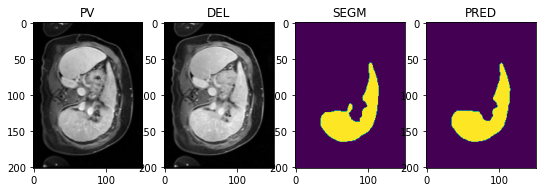

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100998852_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9421881437301636
110.6130641719937
26.32458788755207
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9760873913764954
1.4142135623730951
0.41682218009125815
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


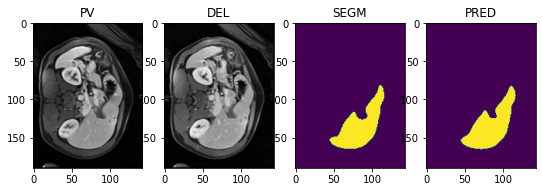

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12370686_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9615539908409119
35.11409973215888
4.604457033929325
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9709862470626831
1.4142135623730951
0.44839487981293924
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


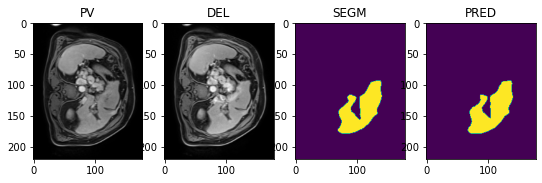

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104184251_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.7397381663322449
88.41860661604325
33.61477533659306
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9744046926498413
1.4142135623730951
0.4826945044842346
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


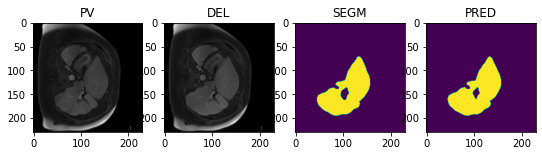

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100353838_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9104458093643188
78.77816956492453
29.01590333677827
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.962356448173523
2.23606797749979
0.591646958075318
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


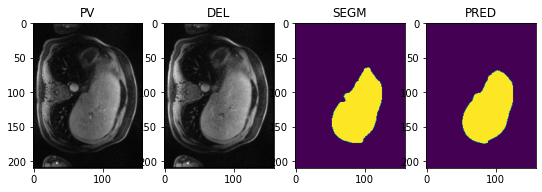

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11655071_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.945063054561615
31.368774282716245
6.429227997350581
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9667565822601318
1.4142135623730951
0.4180364256429482
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


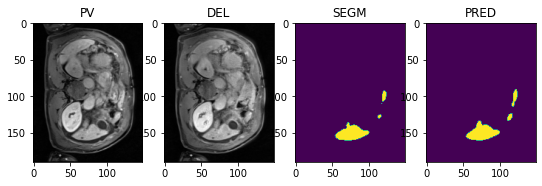

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105258820_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.8907358646392822
69.54854419756032
15.519237242282458
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.977525532245636
1.7320508075688772
0.47896537625786073
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


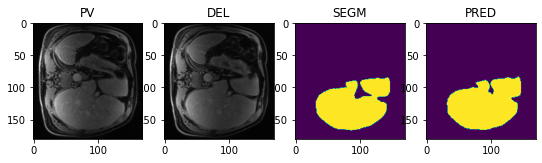

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/10782833_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9707525968551636
90.39026492192899
8.78710603408929
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.977893054485321
1.0
0.36871690450900685
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


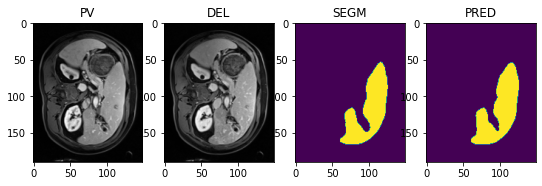

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105047582_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.8961262702941895
70.88723439378913
16.199889711428618
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9568855166435242
2.0
0.6293917575794262
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


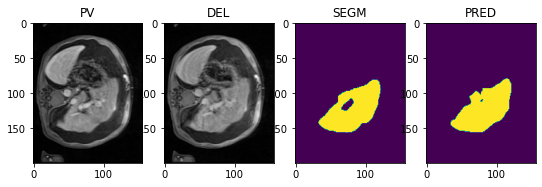

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100559269_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8503220677375793
56.767066380482206
10.98529479591499
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8529869318008423
52.93958767215633
9.080205159953541
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


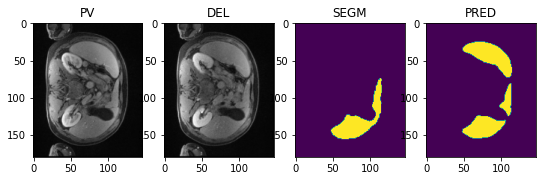

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11157922_T1_PV_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9608364105224609
66.7326755755722
6.6937637833220895
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9705339074134827
1.4142135623730951
0.52159293781177
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


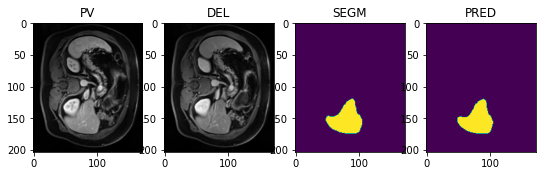

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103977998_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9460626840591431
17.72004514666935
3.473226309311867
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9467237591743469
16.09347693943108
2.1403490288307414
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


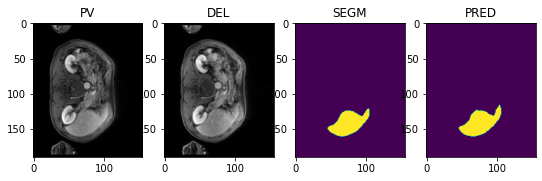

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106605970_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.7645347118377686
68.19090848492928
22.374024785993683
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9614578485488892
6.0
0.5435350290357405
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


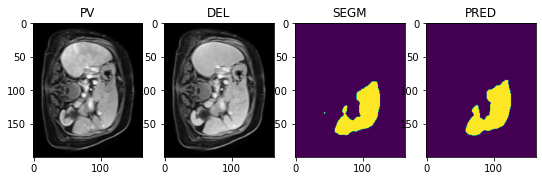

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101166449_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.824349045753479
100.60318086422517
37.66800899217678
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9746286869049072
1.7320508075688772
0.401310430567567
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


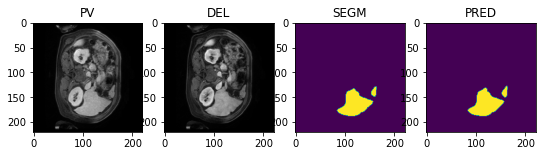

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101693803_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9316191077232361
106.42180206599983
29.63416572283842
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9760740995407104
1.0
0.36966790875275146
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


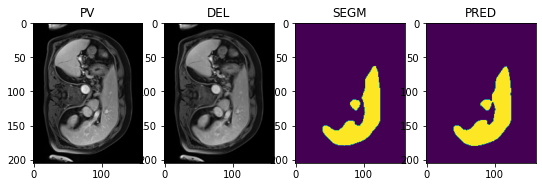

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100488381_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9706321358680725
66.73267494451169
5.555453744873571
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9746710062026978
1.4142135623730951
0.4080919219267502
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


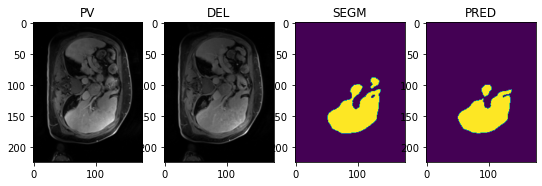

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101446184_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9525934457778931
91.04394543296111
15.21539034982226
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9636687636375427
2.23606797749979
0.5243163625108905
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


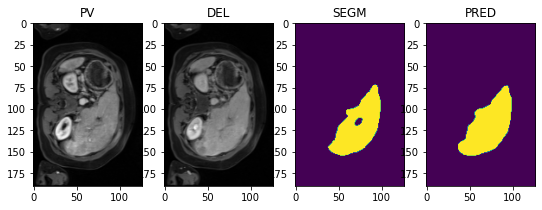

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12132879_T1_PV_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9781510233879089
1.0
0.53764007725649
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9783575534820557
1.0
0.37158651717810837
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


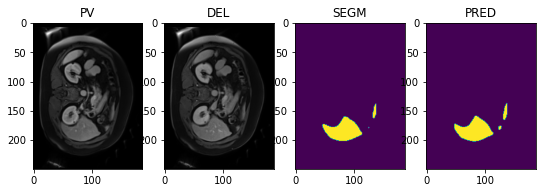

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100207522_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.849655270576477
73.03423854604085
19.029458574215685
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9713728427886963
1.4142135623730951
0.5163055353356379
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


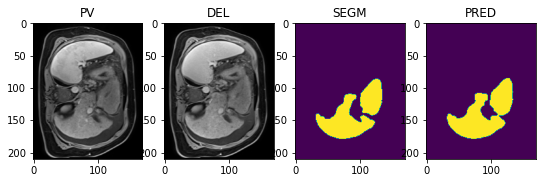

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104350920_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.8726199865341187
72.84915922644544
18.596490683301738
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9592596292495728
2.0
0.6632181113720753
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


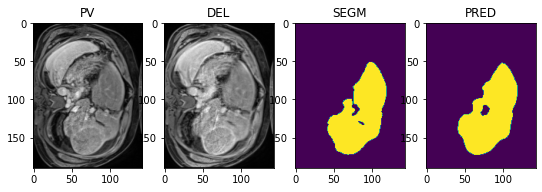

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103442524_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.8685960173606873
65.83312236253116
14.126819951204965
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9745795130729675
1.7320508075688772
0.5145262773669201
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


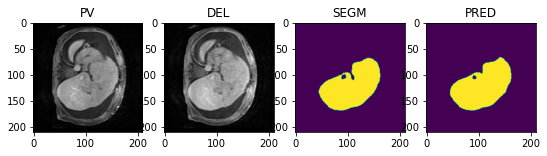

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100354995_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9529715180397034
69.00543449725835
11.048647407200054
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9763811826705933
1.4142135623730951
0.4193959894047496
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


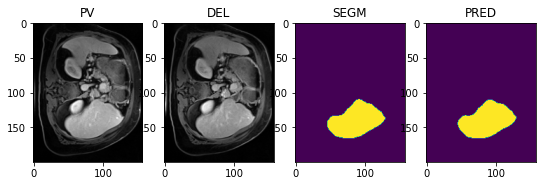

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12169194_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.7993589043617249
106.95372811965059
28.149824206441966
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9697855710983276
1.4142135623730951
0.48571325451106345
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


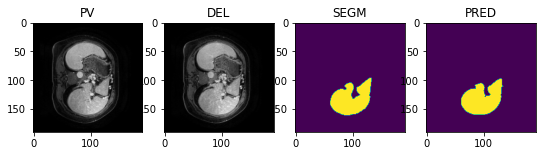

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/9464709_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.8427448868751526
113.43566456621986
39.60341904631018
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.9750437140464783
1.4142135623730951
0.4426547515421694
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


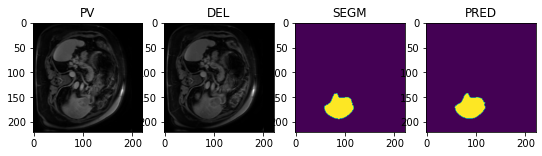

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E102885531_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9676758646965027
2.0
2.1734753150232105
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9687741994857788
1.4142135623730951
0.5244251429381493
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


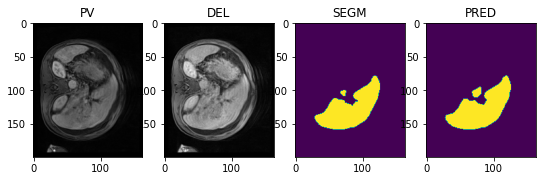

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106731917_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9407990574836731
81.27361147859783
9.979596445713403
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9653836488723755
3.0
0.5348375947912033
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


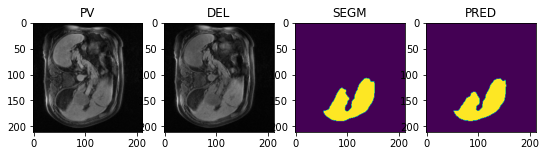

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105877173_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9476326107978821
103.6822067666386
29.16756201700494
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9752888679504395
1.4142135623730951
0.4011573305028409
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


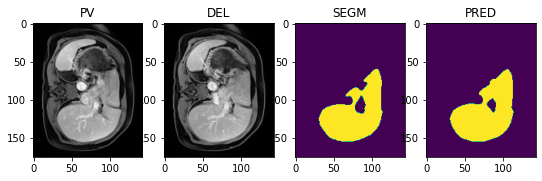

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106096969_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9637202620506287
25.703096250989518
2.7165535149962916
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.969993531703949
1.4142135623730951
0.49027277593730045
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


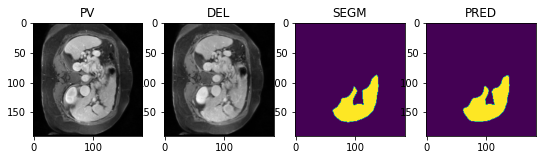

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11571840_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9662991166114807
3.1622776601683795
3.3273400268236353
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9709685444831848
2.0
0.4756784542982121
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


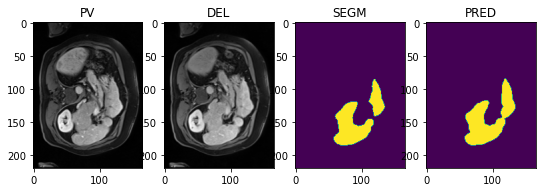

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101753253_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9796283841133118
1.0
0.9923893138980727
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9800136685371399
1.0
0.34698058230409246
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


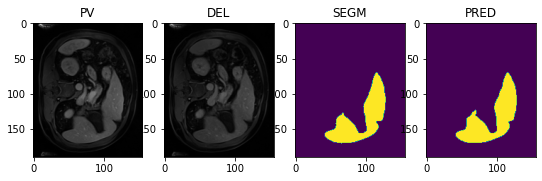

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103922902_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.8558356761932373
74.09453421137081
16.77236168155876
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9702826142311096
2.0
0.5345484781323536
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


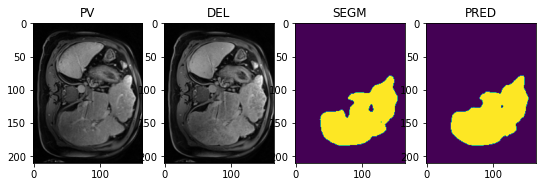

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101453378_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9308987259864807
58.0
17.858701696863267
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9696488380432129
2.0
0.6032290654616681
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


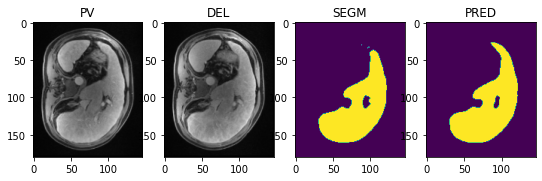

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11397044_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9144808650016785
39.230090491866065
6.7636811538939305
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9741124510765076
1.4142135623730951
0.42925440230974
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


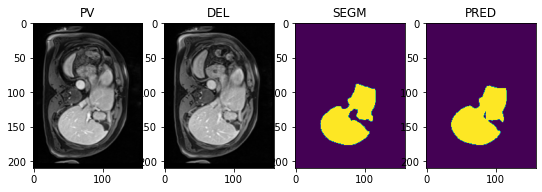

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12922235_T1_PV_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9526095390319824
74.24957912338628
11.971718620629028
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9658080339431763
2.23606797749979
0.7618703364993682
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


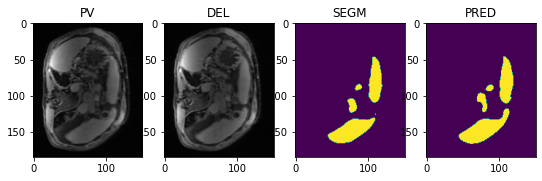

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/10939089_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9787003993988037
1.0
1.036242559088992
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9799394011497498
1.0
0.35202855225176183
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


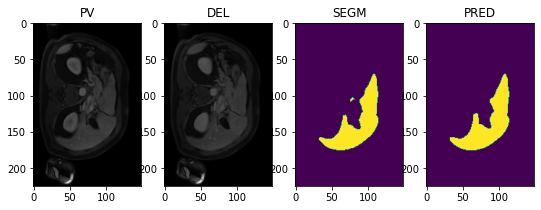

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12957044_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9404283761978149
31.0
5.868354982121793
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9716189503669739
2.0
0.5258273134993637
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


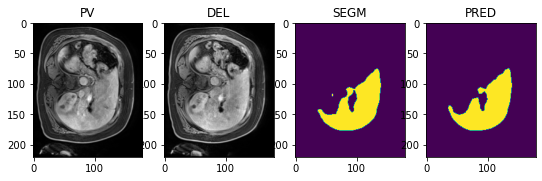

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107891018_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9622989296913147
98.17306147191209
16.192766653289887
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9764306545257568
1.0
0.40506636656874817
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


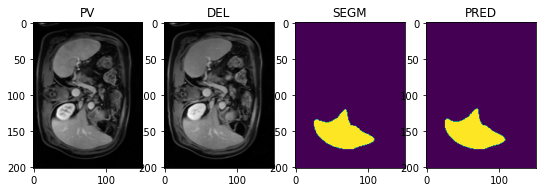

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104332583_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9716489315032959
56.67009742012956
4.550536744858732
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9804825186729431
1.4142135623730951
0.3706802195944376
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


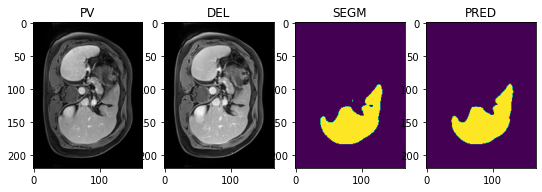

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101547088_T1_PV_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9515822529792786
67.60917097554147
8.840106750679238
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9730590581893921
1.4142135623730951
0.44310373409821885
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


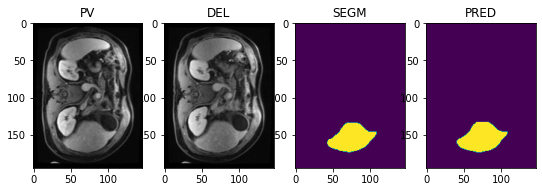

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11524268_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9715986847877502
2.0
2.6473284249480082
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9736937284469604
1.4142135623730951
0.4226588176652222
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


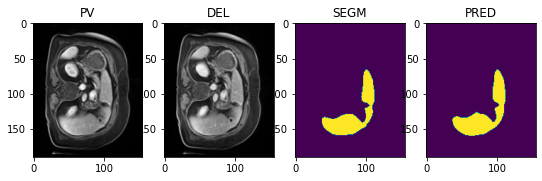

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106458466_T1_PV_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9036591649055481
112.74395762575799
39.37805482879941
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9622219800949097
1.7320508075688772
0.5660423386533878
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


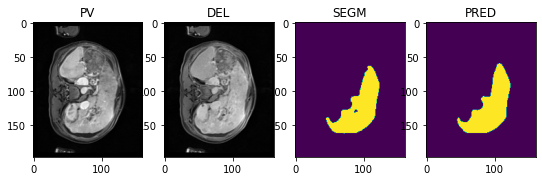

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107235152_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9665959477424622
1.7320508075688772
0.5325690883958907
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9665959477424622
1.7320508075688772
0.5325690883958907
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


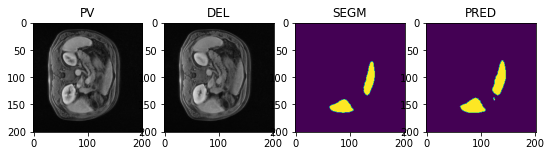

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105198762_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.9539469480514526
69.58448102845921
6.7805332493845025
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.9634917378425598
2.8284271247461903
0.6799759863560194
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


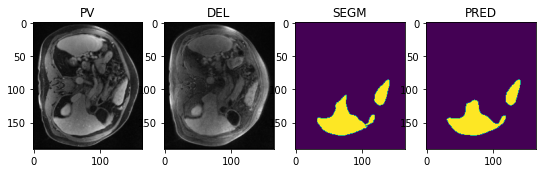

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11148247_T1_PV_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9761557579040527
1.4142135623730951
0.4370584826477025
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9761557579040527
1.4142135623730951
0.4370584826477025
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


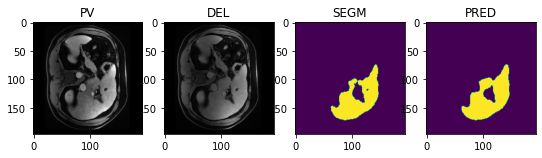

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106751045_T1_PV_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9554431438446045
4.123105625617661
2.9451454436166196
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9586310982704163
2.23606797749979
0.6299024226138062
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


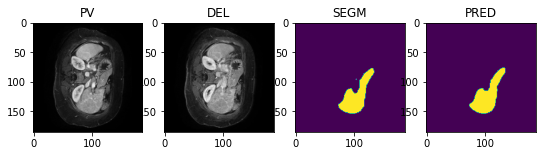

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/9648994_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.785740077495575
85.53946457629952
25.129671825205126
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9748440980911255
1.4142135623730951
0.44255059595394514
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


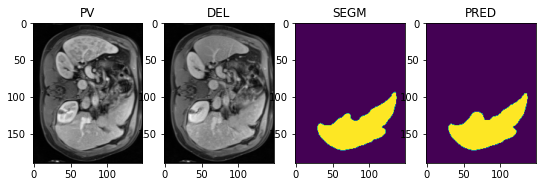

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E102928841_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9736199378967285
85.55787240624684
6.064222299727661
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.976783812046051
1.4142135623730951
0.41192420314080763
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


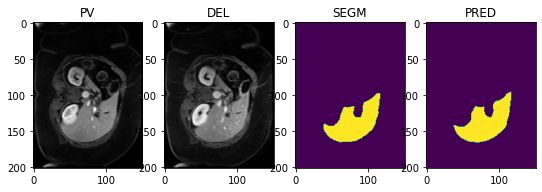

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105426183_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.8674619197845459
71.58142183344701
18.80575536222581
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9780258536338806
1.4142135623730951
0.40148988191107143
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


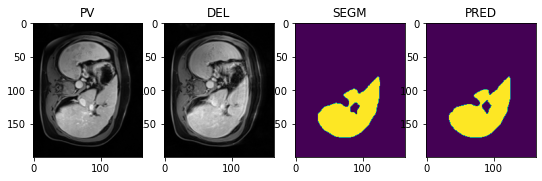

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100142484_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9791260957717896
1.4142135623730951
0.8257836387268066
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.979270875453949
1.4142135623730951
0.4437098524709121
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


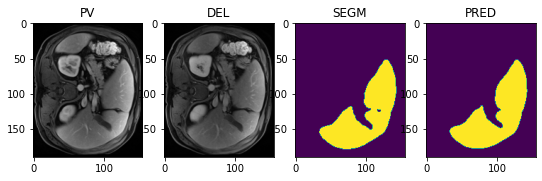

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105829099_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.8142980337142944
60.83584469702052
13.290049298688501
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.9205226302146912
13.390284071681352
2.036142116794626
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


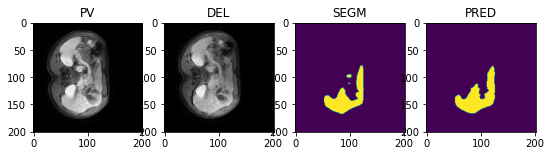

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/9586289_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.6618608236312866
53.16013544000805
16.14315049835716
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.663065493106842
52.15361924162119
15.140927750987064
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


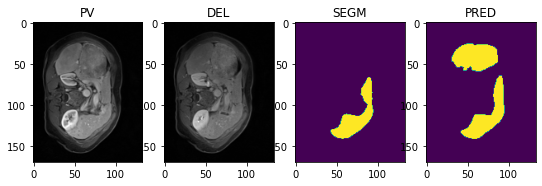

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107156072_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9784749746322632
1.4142135623730951
1.2956138192586293
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9790603518486023
1.4142135623730951
0.37741339542227437
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


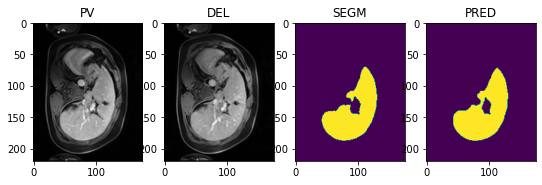

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104998309_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9085487127304077
75.68388202204636
16.92056962593797
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9785997867584229
1.4142135623730951
0.42790425972780766
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


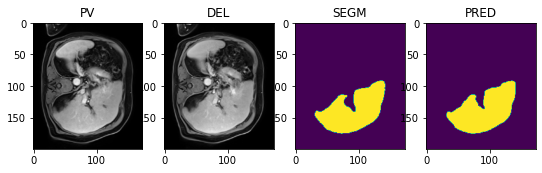

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105615985_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9676148891448975
49.49747468305833
4.507650724324005
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9768208265304565
1.4142135623730951
0.4173637539447746
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


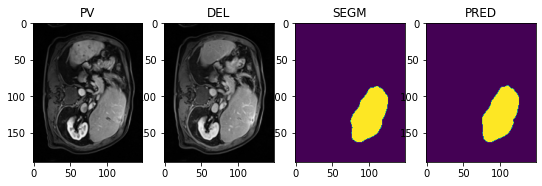

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12916368_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9482300281524658
92.05433178292046
17.19022175467459
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9781206846237183
1.4142135623730951
0.5195410313251599
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


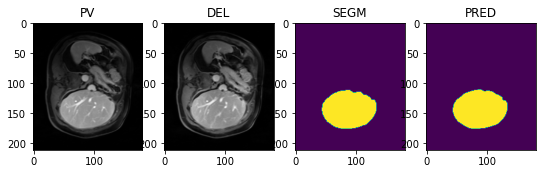

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103814356_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9435076713562012
94.38988289565341
15.494754669053387
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9535295963287354
2.449489742783178
0.8508877228375391
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


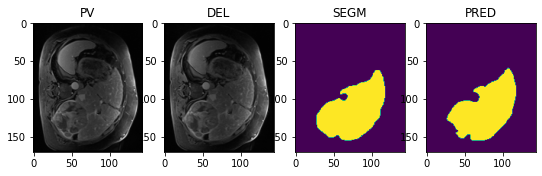

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11022925_T1_PV_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.87482088804245
96.86691888576732
38.11505614263349
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9746336936950684
1.4142135623730951
0.42222823456868097
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


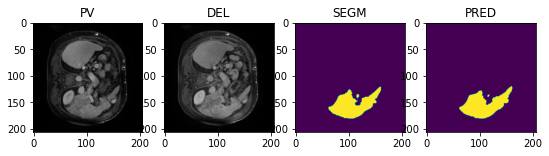

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106533478_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9329732656478882
113.88854198458296
34.25756587866454
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.9688980579376221
1.4142135623730951
0.47768946413913504
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


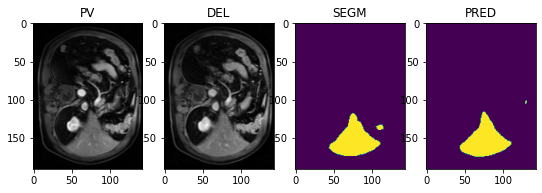

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106851724_T1_PV_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.8821648955345154
58.39520528262573
11.815673307985339
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9637677073478699
2.23606797749979
0.6055965148187672
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


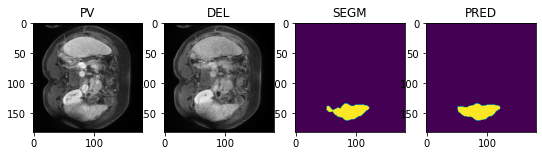

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103511968_T1_PV_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9608407020568848
56.586217403180434
5.894046614623989
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9741889238357544
1.4142135623730951
0.4337456716306178
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


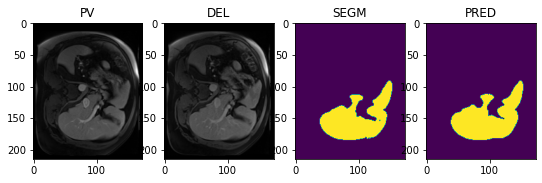

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107553107_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.8835358023643494
99.62730546368783
36.85514272760132
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9708428382873535
1.4142135623730951
0.4208154875670482
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


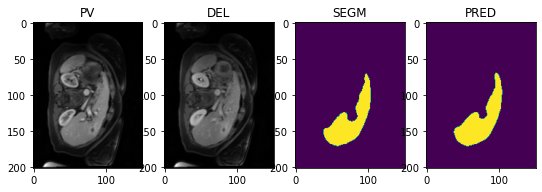

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100588448_T1_PV_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9776438474655151
1.7320508075688772
0.4428400654608552
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9776453375816345
1.7320508075688772
0.4400032361374908
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


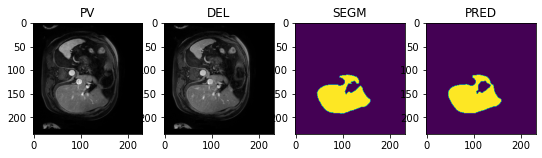

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104134228_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.8572110533714294
106.1178590059185
46.1599005778445
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.971027672290802
1.4142135623730951
0.45661017968333134
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


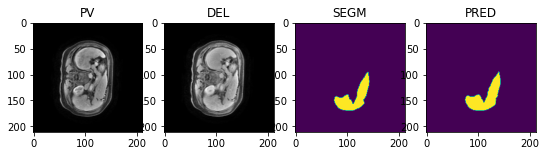

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101686218_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9343813061714172
82.342576875183
10.38894556298654
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9785672426223755
2.0
0.36887015409643087
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


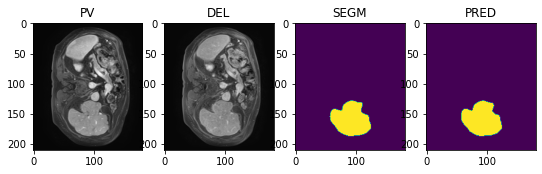

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E100967188_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9720810055732727
29.692580515117804
3.9762941399984055
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9796984791755676
1.0
0.3936619710759006
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


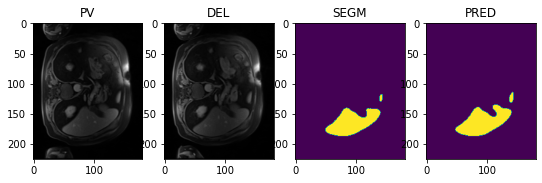

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107476766_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.8975399136543274
79.1580697086532
20.818680214956487
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9577465057373047
1.7320508075688772
0.5324862823511668
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


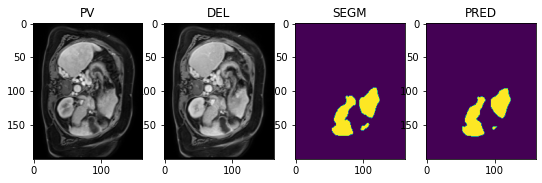

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104250009_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9656545519828796
68.45582503189885
7.672164960847172
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.980963945388794
1.0
0.3597606663209078
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


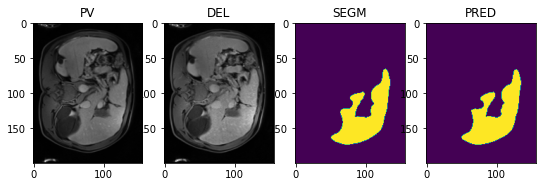

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105152299_T1_PV_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.8100863099098206
74.03377607551839
22.26340772010533
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9676691889762878
1.4142135623730951
0.49419793910517684
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


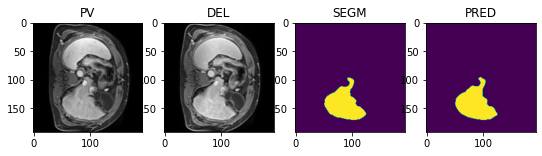

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/11308203_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9486249685287476
112.36436226479702
28.017081777488418
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9783759117126465
1.4142135623730951
0.4027331310540369
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


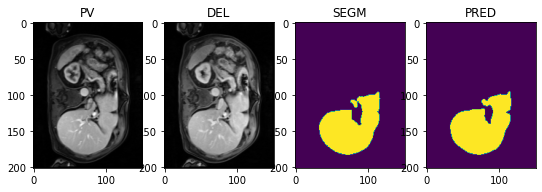

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107046127_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9516991376876831
57.51695233990672
4.98943071649839
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9629732966423035
2.23606797749979
0.5162445721947789
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


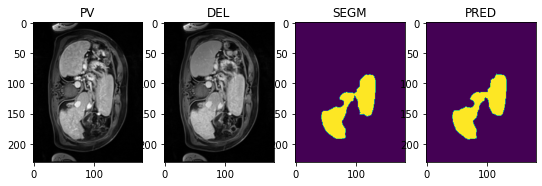

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/13106408_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9650538563728333
2.0
5.334867796673756
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9706108570098877
1.4142135623730951
0.4133313251839615
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


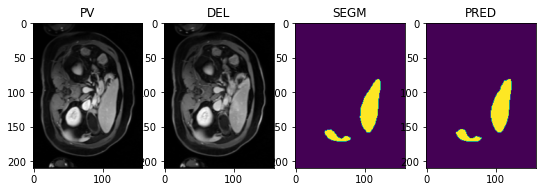

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E102486953_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.6602357625961304
55.767373974394744
17.907756527497984
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.9687647223472595
1.7320508075688772
0.42956123339229535
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


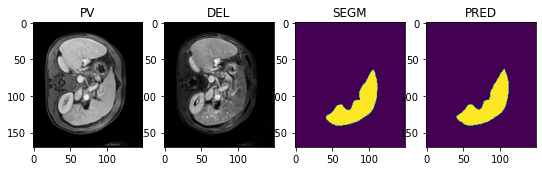

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101055640_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.96149080991745
10.087097609051781
0.5384338310818197
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9615089297294617
10.087097609051781
0.49600628432890503
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


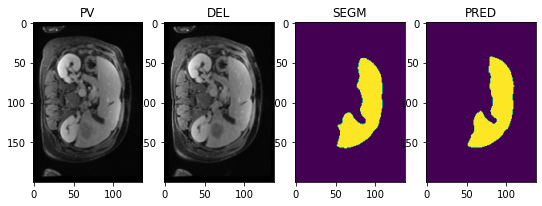

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/10807315_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.8284759521484375
64.25962938835184
15.657011411194594
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9768240451812744
1.4142135623730951
0.3727039628009278
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


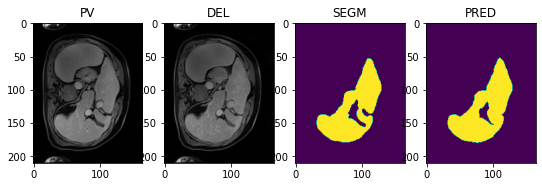

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/13170972_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.8913292288780212
75.55825565694413
13.687262090298072
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.950280487537384
5.196152422706632
1.0649228115217229
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


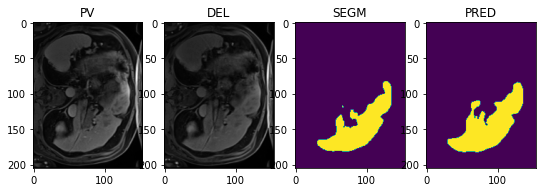

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104594843_T1_PV_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9780097603797913
1.4142135623730951
0.432716802282419
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9780097603797913
1.4142135623730951
0.432716802282419
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


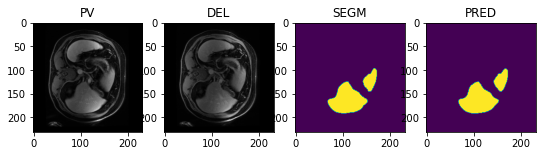

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104034609_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9609184265136719
107.74506949276147
12.786341358622916
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9790706634521484
1.0
0.3750135697032669
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


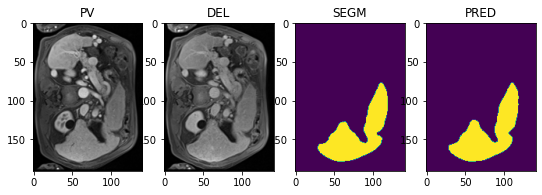

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107774979_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9708502292633057
1.4142135623730951
0.8043199806675476
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.97221440076828
1.4142135623730951
0.4140235461898653
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


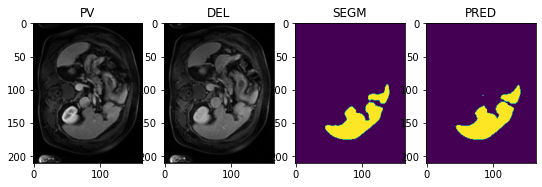

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104900599_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9707638025283813
60.113642247499946
3.873634780437941
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9760836362838745
1.4142135623730951
0.39767320015120133
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


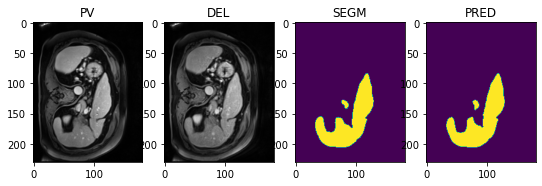

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E104657225_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9333419799804688
73.76313442364011
13.988718459087265
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9609001278877258
2.8284271247461903
0.64443811753053
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


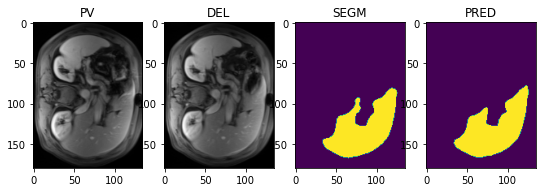

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105599954_T1_PV_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9401803612709045
54.881690936048976
6.3737736046214115
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9652518033981323
2.23606797749979
0.6569295929207052
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


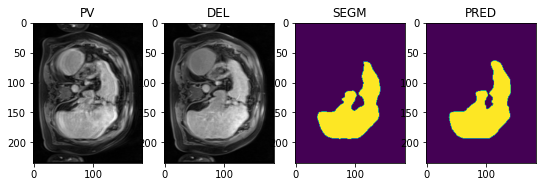

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103570649_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9714376330375671
1.4142135623730951
1.0429922903125597
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9717257022857666
1.4142135623730951
0.45556703867578235
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


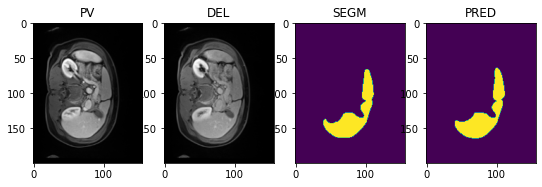

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E105504009_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9749485850334167
1.4142135623730951
0.9180030080191113
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9752134680747986
1.4142135623730951
0.4419405645229009
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


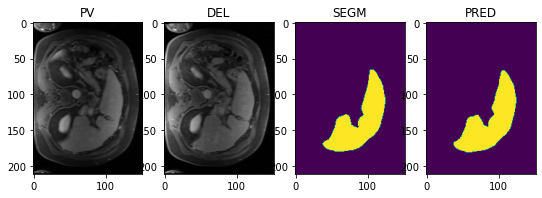

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E103831361_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.904451847076416
95.4725091322104
34.14553338925041
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9732785820960999
1.4142135623730951
0.4840592178556351
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


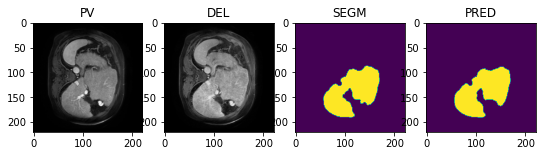

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/10843891_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.963276743888855
100.07996465966606
19.259962924727052
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9761731624603271
1.4142135623730951
0.42846918471560114
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


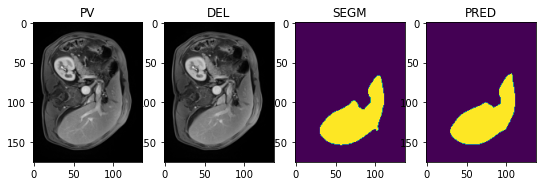

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E101762106_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8268978595733643
86.68852252247657
29.368069717188
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9701426029205322
1.4142135623730951
0.45260664937374934
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


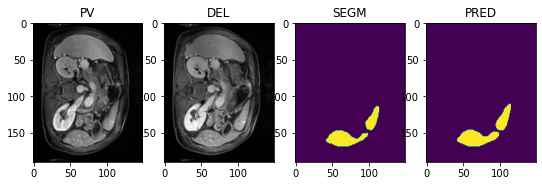

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/12543786_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9073536396026611
67.01939982758888
13.38061872625439
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9588701725006104
2.23606797749979
0.6911408672144348
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


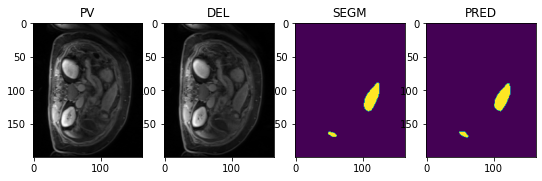

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E107077373_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9415499567985535
51.70106381884226
7.339780423334223
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.976667582988739
1.4142135623730951
0.3955305834786955
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


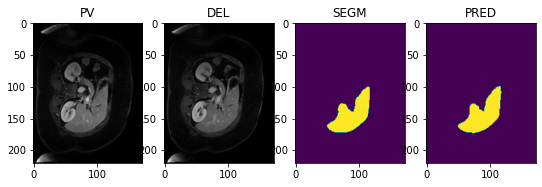

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/E106501028_T1_PV_REG_segm.nii.gz
[0.9443804621696472, 0.9421881437301636, 0.9615539908409119, 0.7397381663322449, 0.9104458093643188, 0.945063054561615, 0.8907358646392822, 0.9707525968551636, 0.8961262702941895, 0.8503220677375793, 0.9608364105224609, 0.9460626840591431, 0.7645347118377686, 0.824349045753479, 0.9316191077232361, 0.9706321358680725, 0.9525934457778931, 0.9781510233879089, 0.849655270576477, 0.8726199865341187, 0.8685960173606873, 0.9529715180397034, 0.7993589043617249, 0.8427448868751526, 0.9676758646965027, 0.9407990574836731, 0.9476326107978821, 0.9637202620506287, 0.9662991166114807, 0.9796283841133118, 0.8558356761932373, 0.9308987259864807, 0.9144808650016785, 0.9526095390319824, 0.9787003993988037, 0.9404283761978149, 0.9622989296913147, 0.9716489315032959, 0.9515822529792786, 0.9715986847877502, 0.9036591649055481, 0.9665959477424622, 0.9539469480514526, 0.976155757904

DICE  POST_DICE        HD95  POST_HD95  InferenceTime  \
0  0.944380   0.971792   92.966658   1.414214       0.010669   
1  0.942188   0.976087  110.613064   1.414214       0.005459   
2  0.961554   0.970986   35.114100   1.414214       0.008284   
3  0.739738   0.974405   88.418607   1.414214       0.034758   
4  0.910446   0.962356   78.778170   2.236068       0.011187   

                                AUTOMATED-LIVER-SEGM  EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PV-DEL  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PV-DEL  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PV-DEL  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PV-DEL  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  2mpMRI-PV-DEL

In [49]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
    output_path= OUTPUT_PATH)
    #max_eval = 2)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = '2mpMRI-PV-DEL'
df_test_results.head()

In [51]:
df_test_results.to_csv('../Results/Results-2mpMRI-Net_PV-DEL.csv')

# Public LiverHccSeg Dataset for Benchmark Testing

In [45]:
def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)
            
            
            x = torch.cat((pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PV_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PV_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PV_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PV_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [46]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

In [10]:
## Load Public LiverHccSeg Dataset

import glob

LiverHccSeg_pre_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pre.nii.gz'
LiverHccSeg_art_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art.nii.gz'
LiverHccSeg_pv_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pv.nii.gz'
LiverHccSeg_del_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_del.nii.gz'
LiverHccSeg_segm_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*rater1_liver.nii.gz'

LiverHccSeg_pre_paths = glob.glob(LiverHccSeg_pre_path)
LiverHccSeg_art_paths = glob.glob(LiverHccSeg_art_path)
LiverHccSeg_pv_paths = glob.glob(LiverHccSeg_pv_path)
LiverHccSeg_del_paths = glob.glob(LiverHccSeg_del_path)
LiverHccSeg_segm_paths = glob.glob(LiverHccSeg_segm_path)

LiverHccSeg_accs = []
for i in LiverHccSeg_pre_paths:
    LiverHccSeg_accs.append(i.split('/')[-3])
    
df_LiverHccSeg_imgs = pd.DataFrame({'ACCESSION_ID': LiverHccSeg_accs, 'PRE' : LiverHccSeg_pre_paths,
                                   'ART' : LiverHccSeg_art_paths, 'PV' : LiverHccSeg_pv_paths, 
                                    'DEL' : LiverHccSeg_del_paths, 'SEGM' : LiverHccSeg_segm_paths })

df_LiverHccSeg_imgs

ACCESSION_ID                                                PRE  \
0   TCGA-G3-A25T  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   TCGA-G3-AAV2  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   TCGA-G3-A3CJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   TCGA-DD-A4NH  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   TCGA-BC-4073  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   TCGA-DD-A4NB  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   TCGA-G3-A7M7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   TCGA-G3-AAV1  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   TCGA-G3-AAV3  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   TCGA-G3-AAV7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  TCGA-BC-A3KG  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  TCGA-BC-A69I  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  TCGA-BC-A5W4  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  TCGA-BC-A216  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  TCGA-BC-A10Y  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  TCGA-DD-A4NF  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  TCGA-DD-A4NJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                  ART  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                   PV  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                  DEL  \
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  /tensor5/data1/mgross/Liver/LiverHccSeg/

In [48]:
LiverHccSeg_test_data_dict = df_LiverHccSeg_imgs.to_dict('records')
print('Number of LiverHccSeg testing files: ', len(LiverHccSeg_test_data_dict))

Number of LiverHccSeg testing files:  17


In [49]:
LiverHccSeg_test_ds = monai.data.Dataset(
    data=LiverHccSeg_test_data_dict, transform=test_transforms)
LiverHccSeg_test_loader = DataLoader(LiverHccSeg_test_ds, batch_size=1, num_workers=4)

torch.Size([3, 1, 180, 180, 112])
torch.Size([3, 1, 180, 180, 112])
TCGA-G3-A25T
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.10535145550966263
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.08942414820194244


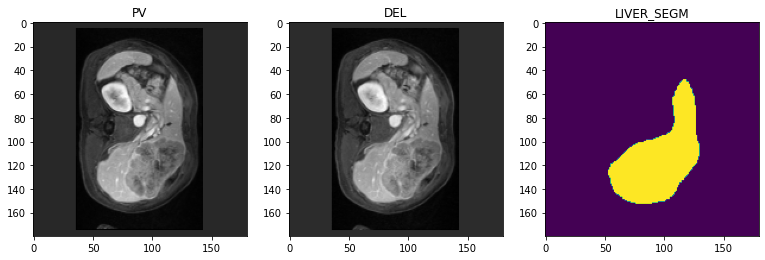

TCGA-G3-AAV2
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.15688380599021912
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: 0.13756035268306732


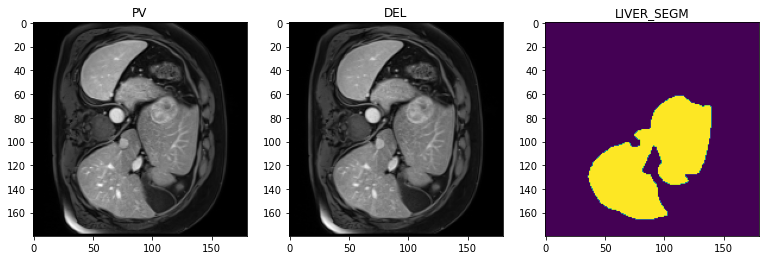

TCGA-G3-A3CJ
PV shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
PV mean: 0.0006159089389257133
DEL shape: torch.Size([180, 180, 112]), label shape: torch.Size([180, 180, 112])
DEL mean: -0.0002303773071616888


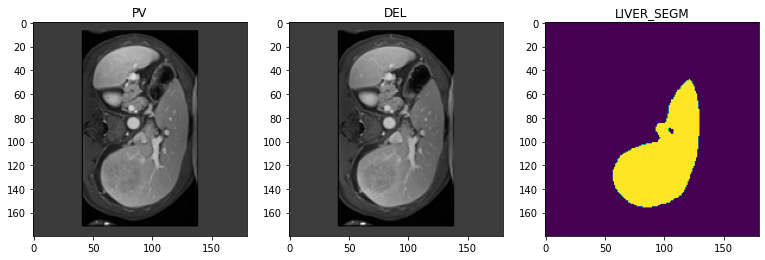

In [50]:
check_ds = monai.data.Dataset(data=LiverHccSeg_test_data_dict[:3], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)

num_display = 10
if check_data['PV'].shape[0] < num_display:
    num_display = check_data['PV'].shape[0]

for i in range(num_display):
    acc_id, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i], check_data['PV'][i][0], check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
            
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))

    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    


    slice_num = PV.shape[2]//2
    
    plt.figure('check', (13, 15))

   

    plt.subplot(1, 3, 1)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


In [54]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg'


0it [00:00, ?it/s]

torch.Size([2, 170, 107, 100])
torch.Size([1, 170, 107, 100])
torch.Size([1, 2, 170, 107, 100])
0.9125186800956726
5.385164807134504
2.5165114682072804
torch.Size([2, 170, 107, 100])
torch.Size([1, 170, 107, 100])
torch.Size([1, 2, 170, 107, 100])
0.9131873250007629
5.0
1.7001485828369882
torch.Size([1, 2, 170, 107, 100])
torch.Size([1, 170, 107, 100])


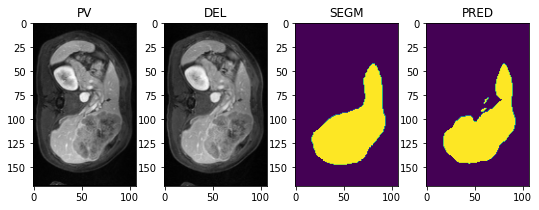

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-A25T_segm.nii.gz
torch.Size([2, 180, 180, 110])
torch.Size([1, 180, 180, 110])
torch.Size([1, 2, 180, 180, 110])
0.9112305641174316
72.73926037567333
25.43438996925056
torch.Size([2, 180, 180, 110])
torch.Size([1, 180, 180, 110])
torch.Size([1, 2, 180, 180, 110])
0.9551669359207153
2.23606797749979
0.7718769310827994
torch.Size([1, 2, 180, 180, 110])
torch.Size([1, 180, 180, 110])


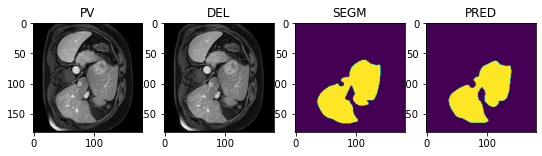

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-AAV2_segm.nii.gz
torch.Size([2, 165, 98, 112])
torch.Size([1, 165, 98, 112])
torch.Size([1, 2, 165, 98, 112])
0.8959481716156006
21.42428528562855
5.21077668149222
torch.Size([2, 165, 98, 112])
torch.Size([1, 165, 98, 112])
torch.Size([1, 2, 165, 98, 112])
0.8978675603866577
14.966629547095765
2.326164649474919
torch.Size([1, 2, 165, 98, 112])
torch.Size([1, 165, 98, 112])


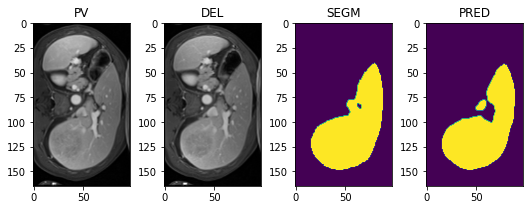

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-A3CJ_segm.nii.gz
torch.Size([2, 201, 151, 86])
torch.Size([1, 201, 151, 86])
torch.Size([1, 2, 201, 151, 86])
0.5433695912361145
55.64800071022652
22.3097859156842
torch.Size([2, 201, 151, 86])
torch.Size([1, 201, 151, 86])
torch.Size([1, 2, 201, 151, 86])
0.6837278604507446
44.82186966202994
13.295166913073317
torch.Size([1, 2, 201, 151, 86])
torch.Size([1, 201, 151, 86])


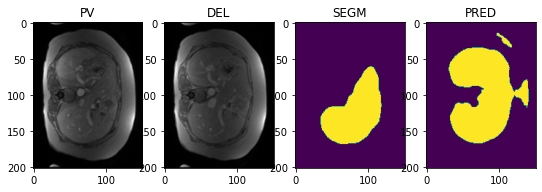

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-DD-A4NH_segm.nii.gz
torch.Size([2, 200, 150, 120])
torch.Size([1, 200, 150, 120])
torch.Size([1, 2, 200, 150, 120])
0.9552980065345764
2.23606797749979
0.8501679807837675
torch.Size([2, 200, 150, 120])
torch.Size([1, 200, 150, 120])
torch.Size([1, 2, 200, 150, 120])
0.9553762078285217
2.23606797749979
0.7260681750937016
torch.Size([1, 2, 200, 150, 120])
torch.Size([1, 200, 150, 120])


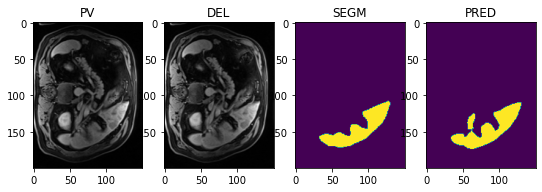

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-4073_segm.nii.gz
torch.Size([2, 201, 200, 115])
torch.Size([1, 201, 200, 115])
torch.Size([1, 2, 201, 200, 115])
0.9031049609184265
96.21330469326995
30.408414390543133
torch.Size([2, 201, 200, 115])
torch.Size([1, 201, 200, 115])
torch.Size([1, 2, 201, 200, 115])
0.9414983987808228
2.449489742783178
1.0291596774753797
torch.Size([1, 2, 201, 200, 115])
torch.Size([1, 201, 200, 115])


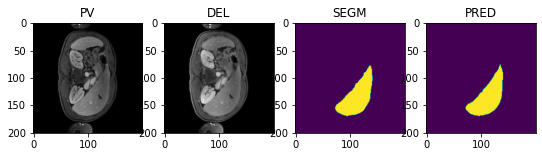

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-DD-A4NB_segm.nii.gz
torch.Size([2, 190, 155, 96])
torch.Size([1, 190, 155, 96])
torch.Size([1, 2, 190, 155, 96])
0.9397618770599365
69.3159429904368
9.264437387712238
torch.Size([2, 190, 155, 96])
torch.Size([1, 190, 155, 96])
torch.Size([1, 2, 190, 155, 96])
0.9470390677452087
3.1622776601683795
0.7560289084820452
torch.Size([1, 2, 190, 155, 96])
torch.Size([1, 190, 155, 96])


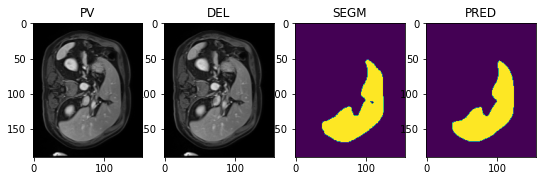

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-A7M7_segm.nii.gz
torch.Size([2, 225, 204, 122])
torch.Size([1, 225, 204, 122])
torch.Size([1, 2, 225, 204, 122])
0.932399332523346
2.449489742783178
1.6761989270570312
torch.Size([2, 225, 204, 122])
torch.Size([1, 225, 204, 122])
torch.Size([1, 2, 225, 204, 122])
0.934557318687439
2.449489742783178
0.8531519017198613
torch.Size([1, 2, 225, 204, 122])
torch.Size([1, 225, 204, 122])


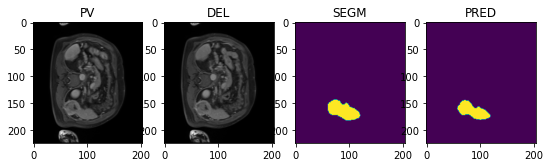

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-AAV1_segm.nii.gz
torch.Size([2, 175, 175, 110])
torch.Size([1, 175, 175, 110])
torch.Size([1, 2, 175, 175, 110])
0.9138239026069641
93.34880824091971
26.488573109781868
torch.Size([2, 175, 175, 110])
torch.Size([1, 175, 175, 110])
torch.Size([1, 2, 175, 175, 110])
0.949092447757721
2.23606797749979
0.9124156641867984
torch.Size([1, 2, 175, 175, 110])
torch.Size([1, 175, 175, 110])


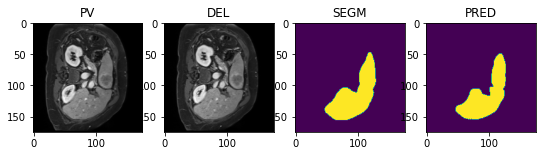

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-AAV3_segm.nii.gz
torch.Size([2, 180, 119, 150])
torch.Size([1, 180, 119, 150])
torch.Size([1, 2, 180, 119, 150])
0.9131273627281189
96.7594955697448
12.546164478433207
torch.Size([2, 180, 119, 150])
torch.Size([1, 180, 119, 150])
torch.Size([1, 2, 180, 119, 150])
0.9265382289886475
4.123105625617661
1.1010173518066708
torch.Size([1, 2, 180, 119, 150])
torch.Size([1, 180, 119, 150])


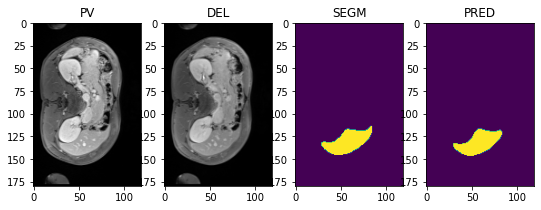

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-G3-AAV7_segm.nii.gz
torch.Size([2, 180, 147, 110])
torch.Size([1, 180, 147, 110])
torch.Size([1, 2, 180, 147, 110])
0.9293179512023926
73.97296618260026
21.438681833723386
torch.Size([2, 180, 147, 110])
torch.Size([1, 180, 147, 110])
torch.Size([1, 2, 180, 147, 110])
0.9629986882209778
2.0
0.7662940904749378
torch.Size([1, 2, 180, 147, 110])
torch.Size([1, 180, 147, 110])


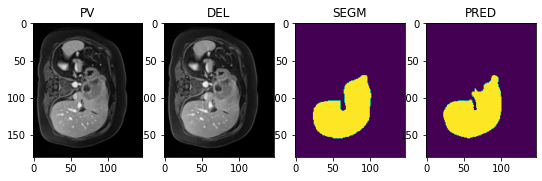

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-A3KG_segm.nii.gz
torch.Size([2, 200, 163, 153])
torch.Size([1, 200, 163, 153])
torch.Size([1, 2, 200, 163, 153])
0.8818307518959045
56.789083458002736
11.848068070828262
torch.Size([2, 200, 163, 153])
torch.Size([1, 200, 163, 153])
torch.Size([1, 2, 200, 163, 153])
0.9435808658599854
2.8284271247461903
0.9280202633016924
torch.Size([1, 2, 200, 163, 153])
torch.Size([1, 200, 163, 153])


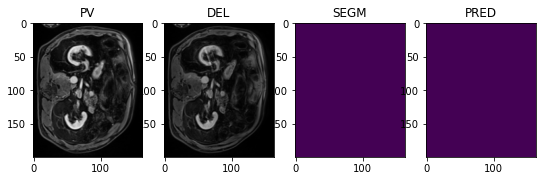

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-A69I_segm.nii.gz
torch.Size([2, 215, 162, 125])
torch.Size([1, 215, 162, 125])
torch.Size([1, 2, 215, 162, 125])
0.7686673998832703
70.07139216541941
18.503100231366666
torch.Size([2, 215, 162, 125])
torch.Size([1, 215, 162, 125])
torch.Size([1, 2, 215, 162, 125])
0.926253080368042
5.0990195135927845
1.3798156999658417
torch.Size([1, 2, 215, 162, 125])
torch.Size([1, 215, 162, 125])


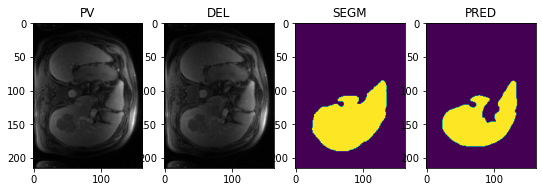

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-A5W4_segm.nii.gz
torch.Size([2, 201, 201, 99])
torch.Size([1, 201, 201, 99])
torch.Size([1, 2, 201, 201, 99])
0.9217775464057922
83.82004479193931
14.813056301733939
torch.Size([2, 201, 201, 99])
torch.Size([1, 201, 201, 99])
torch.Size([1, 2, 201, 201, 99])
0.9332167506217957
5.0990195135927845
1.136398821383445
torch.Size([1, 2, 201, 201, 99])
torch.Size([1, 201, 201, 99])


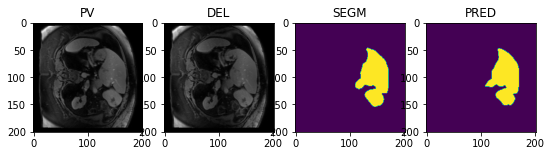

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-A216_segm.nii.gz
torch.Size([2, 191, 143, 98])
torch.Size([1, 191, 143, 98])
torch.Size([1, 2, 191, 143, 98])
0.5298175811767578
96.1977130705299
31.194423285122433
torch.Size([2, 191, 143, 98])
torch.Size([1, 191, 143, 98])
torch.Size([1, 2, 191, 143, 98])
0.5375112891197205
68.18907529742775
22.00966193884747
torch.Size([1, 2, 191, 143, 98])
torch.Size([1, 191, 143, 98])


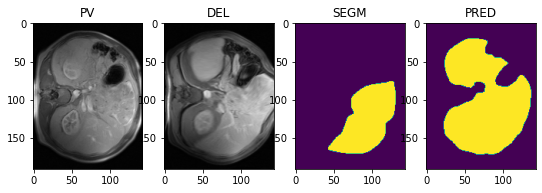

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-BC-A10Y_segm.nii.gz
torch.Size([2, 201, 151, 90])
torch.Size([1, 201, 151, 90])
torch.Size([1, 2, 201, 151, 90])
0.9110806584358215
93.5125657804125
15.105989491349293
torch.Size([2, 201, 151, 90])
torch.Size([1, 201, 151, 90])
torch.Size([1, 2, 201, 151, 90])
0.9263385534286499
3.0
0.9681736221793958
torch.Size([1, 2, 201, 151, 90])
torch.Size([1, 201, 151, 90])


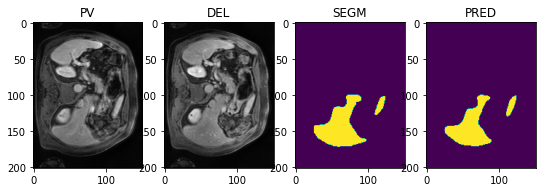

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-DD-A4NF_segm.nii.gz
torch.Size([2, 201, 151, 105])
torch.Size([1, 201, 151, 105])
torch.Size([1, 2, 201, 151, 105])
0.6942207217216492
69.8426803609369
23.691343807184797
torch.Size([2, 201, 151, 105])
torch.Size([1, 201, 151, 105])
torch.Size([1, 2, 201, 151, 105])
0.9263415932655334
3.1622776601683795
1.3189294184796216
torch.Size([1, 2, 201, 151, 105])
torch.Size([1, 201, 151, 105])


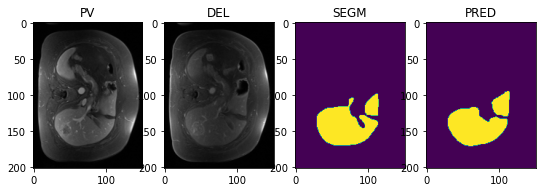

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/LiverHccSeg/TCGA-DD-A4NJ_segm.nii.gz
[0.9125186800956726, 0.9112305641174316, 0.8959481716156006, 0.5433695912361145, 0.9552980065345764, 0.9031049609184265, 0.9397618770599365, 0.932399332523346, 0.9138239026069641, 0.9131273627281189, 0.9293179512023926, 0.8818307518959045, 0.7686673998832703, 0.9217775464057922, 0.5298175811767578, 0.9110806584358215, 0.6942207217216492]


DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  17.000000  17.000000  17.000000  17.000000      17.000000
mean    0.850429   0.897664  62.336839  10.179934       0.005228
std     0.134673   0.112266  33.979970  18.171100       0.002937
min     0.529818   0.537511   2.236068   2.000000       0.003097
25%     0.881831   0.926253  55.648001   2.449490       0.003352
50%     0.911231   0.933217  70.071392   3.162278       0.003948
75%     0.921778   0.947039  93.348808   5.099020       0.005630
max     0.955298   0.962999  96.759496  68.189075       0.012226

In [86]:
roi_size = (224, 224, 128)

df_LiverHccSeg_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= LiverHccSeg_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path=OUTPUT_PATH) #, max_eval = 2

torch.cuda.empty_cache()
df_LiverHccSeg_test_results['EXPERIMENT_ID'] = 'LiverHccSeg-PV-DEL'
df_LiverHccSeg_test_results.describe()

In [88]:
df_LiverHccSeg_test_results.describe()

DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  17.000000  17.000000  17.000000  17.000000      17.000000
mean    0.850429   0.897664  62.336839  10.179934       0.005228
std     0.134673   0.112266  33.979970  18.171100       0.002937
min     0.529818   0.537511   2.236068   2.000000       0.003097
25%     0.881831   0.926253  55.648001   2.449490       0.003352
50%     0.911231   0.933217  70.071392   3.162278       0.003948
75%     0.921778   0.947039  93.348808   5.099020       0.005630
max     0.955298   0.962999  96.759496  68.189075       0.012226

In [90]:
df_LiverHccSeg_test_results.to_csv('../LiverHccSegTestingResults/LiverHccSeg-PV-DEL.csv')

## External Testing

In [51]:
def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    
            pv_images =  test_data["PV"].to(device)
            del_images =  test_data["DEL"].to(device)
            
            
            x = torch.cat((pv_images, del_images) ,dim=1)
            y = test_data['SEGM'].cpu()




            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:
                pv_img = pv_images.detach().cpu()
                del_img = del_images.detach().cpu()
                


                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 4, 1)
                plt.title('PV')
                plt.imshow(pv_img[0,0,:,:,slice_num], cmap='gray')

                plt.subplot(1, 4, 2)
                plt.title('DEL')
                plt.imshow(del_img[0,0,:,:,slice_num], cmap='gray')

            
                plt.subplot(1, 4, 3)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 4, 4)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['PV_meta_dict']['affine'][0].numpy()
                original_affine = test_data['PV_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['PV_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['PV_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [52]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

In [57]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_DEL','PV',  'SEGM']]



df_external_testing.rename(columns={'PV_DEL' : 'DEL',
                                    'LIVER': 'SEGM'}, inplace = True)
df_external_testing.columns

Index(['ACCESSION_ID', 'DEL', 'PV', 'SEGM'], dtype='object')

In [58]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [59]:
external_test_ds = monai.data.Dataset(
    data=external_test_data_dict, transform=test_transforms)
external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

torch.Size([3, 1, 230, 230, 125])
torch.Size([3, 1, 230, 230, 125])
tensor(1)
PV shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
PV mean: 0.1202332153916359
DEL shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
DEL mean: 0.08329281955957413


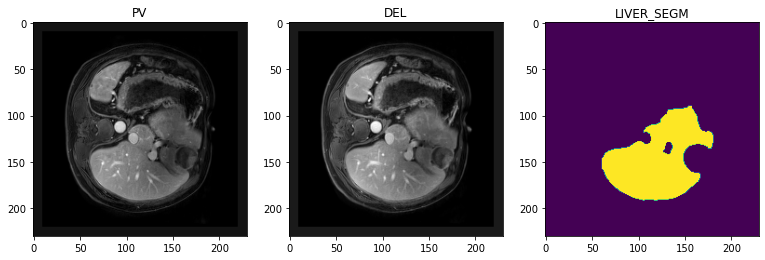

tensor(3)
PV shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
PV mean: 0.4182465672492981
DEL shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
DEL mean: 0.3483874201774597


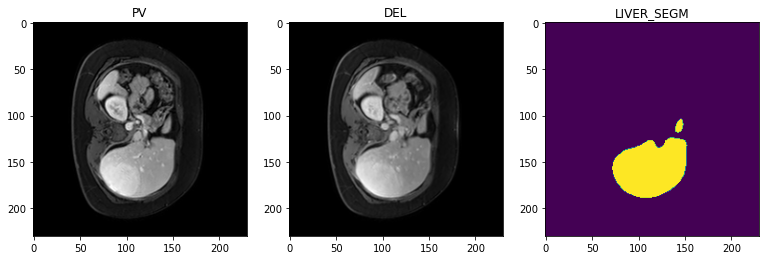

tensor(4)
PV shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
PV mean: 0.2232285439968109
DEL shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
DEL mean: 0.1356281340122223


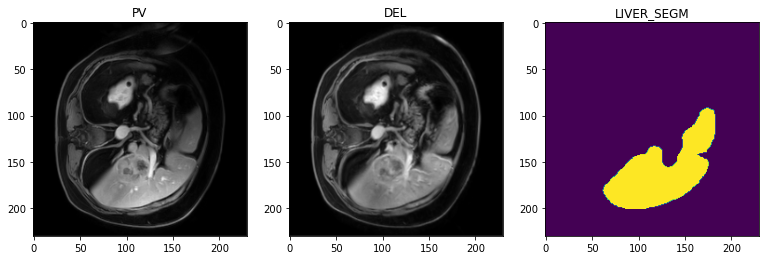

In [60]:
check_ds = monai.data.Dataset(data=external_test_data_dict[:3], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0, collate_fn=pad_list_data_collate) #pad_list_data_collate, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['PV'].shape)
print(check_data['DEL'].shape)

num_display = 10
if check_data['PV'].shape[0] < num_display:
    num_display = check_data['PV'].shape[0]

for i in range(num_display):
    acc_id, PV, DEL , liver_label = (check_data['ACCESSION_ID'][i], check_data['PV'][i][0], check_data['DEL'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
            
    print('PV shape: {}, label shape: {}'.format(PV.shape, liver_label.shape))
    print('PV mean: {}'.format(np.mean(PV.numpy())))

    
    print('DEL shape: {}, label shape: {}'.format(DEL.shape, liver_label.shape))
    print('DEL mean: {}'.format(np.mean(DEL.numpy())))
    


    slice_num = PV.shape[2]//2
    
    plt.figure('check', (13, 15))

   

    plt.subplot(1, 3, 1)
    plt.title('PV')
    plt.imshow(PV[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.title('DEL')
    plt.imshow(DEL[:,:,slice_num], cmap='gray')
    

    plt.subplot(1, 3, 3)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


In [64]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS'


0it [00:00, ?it/s]

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.968851625919342
2.0
0.6399159597443612
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9689095616340637
2.0
0.548264910073803
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


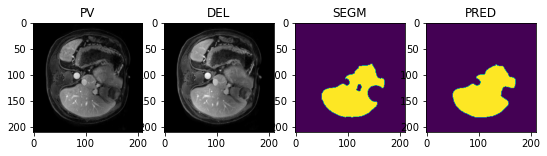

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(1)_segm.nii.gz
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9394067525863647
104.98999931963532
16.64934164693051
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9719688296318054
3.4641016151377544
0.49895020079951435
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


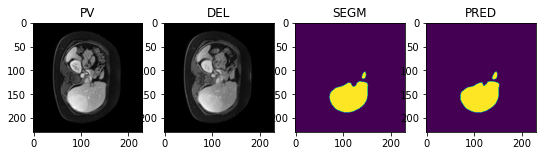

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(3)_segm.nii.gz
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9309427738189697
37.86819245752297
5.030274820532523
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9525991082191467
2.0
0.9320327794011458
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


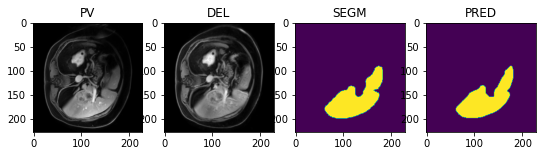

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(4)_segm.nii.gz
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.9737615585327148
1.4142135623730951
0.7528498142976358
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.974108099937439
1.4142135623730951
0.4654048913182596
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


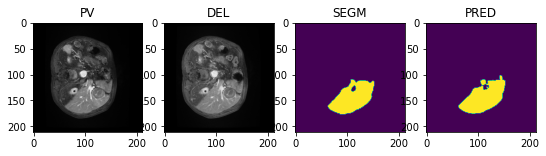

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(6)_segm.nii.gz
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.9223785996437073
88.12491134747314
29.22872349625801
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.9608632922172546
2.8284271247461903
0.5567959436946539
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


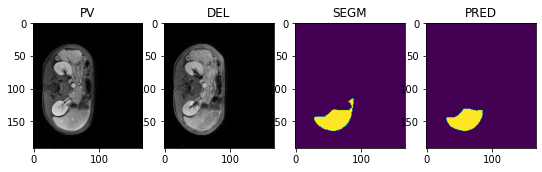

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(10)_segm.nii.gz
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9580685496330261
11.357816691600547
1.6973871262509763
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9603055715560913
7.0
1.0680490914229133
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


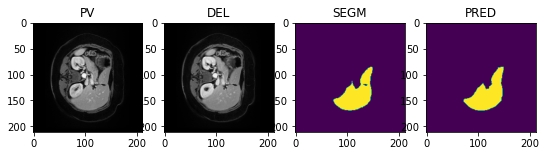

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(11)_segm.nii.gz
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9634048938751221
3.0
1.003776105423717
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9640457630157471
3.0
0.5669818293077028
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


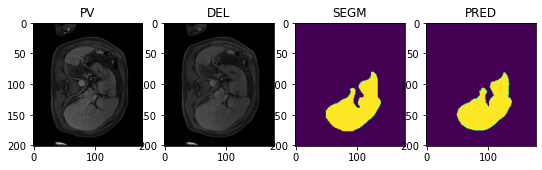

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(12)_segm.nii.gz
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.9303933382034302
15.588457268119896
2.869220587459004
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.959106981754303
2.23606797749979
0.7012855387963679
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


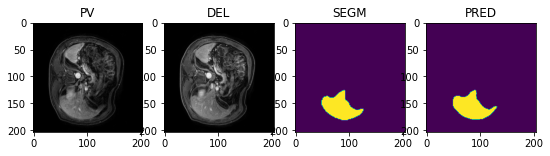

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(17)_segm.nii.gz
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9467885494232178
12.083045973594572
2.4426379276472128
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9552603363990784
3.0
0.7106419735532177
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


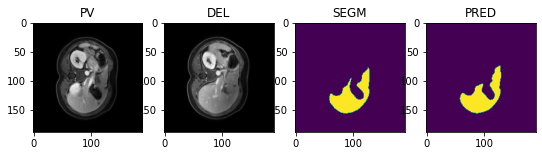

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(18)_segm.nii.gz
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9688972234725952
2.0
1.2571052901244366
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9695466756820679
1.7320508075688772
0.5439366479032975
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


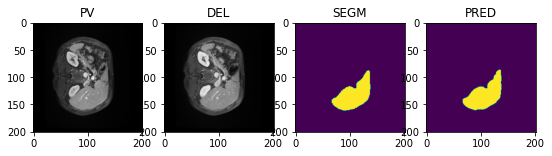

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(19)_segm.nii.gz
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9636591076850891
3.605551275463989
0.9744435197060821
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9637258052825928
3.3166247903554
0.86747715707446
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


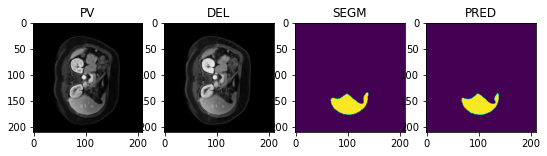

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(22)_segm.nii.gz
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9253442883491516
105.92450141492289
35.963837997877775
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9748106002807617
1.4142135623730951
0.5015806735143935
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


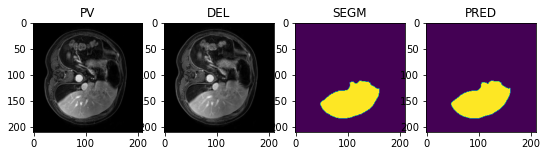

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(32)_segm.nii.gz
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9500054121017456
6.629459027890139
1.3745366371429586
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.9500250220298767
6.48074069840786
1.3697180449553306
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


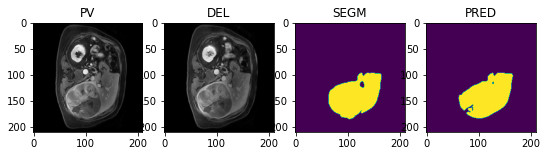

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(35)_segm.nii.gz
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9549739360809326
5.0
3.142105993578024
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9575182199478149
3.3166247903554
0.638981760740798
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


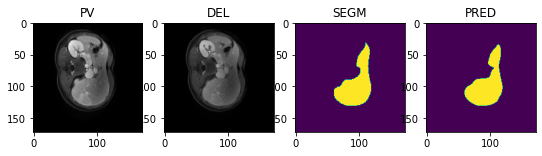

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(40)_segm.nii.gz
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9018257260322571
73.87455575949265
22.22789546429452
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9797150492668152
1.4142135623730951
0.4582156444409458
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


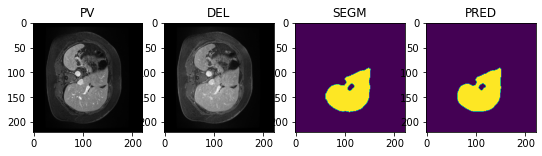

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(55)_segm.nii.gz
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9575504660606384
16.55294535724685
2.853477637719868
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9671565294265747
2.23606797749979
0.6735793681422956
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


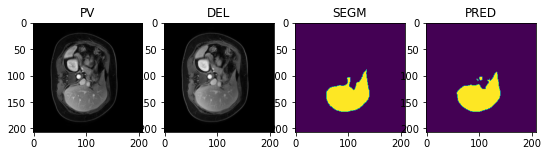

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/2-phases/PV-DEL/PARIS/tensor(59)_segm.nii.gz
[0.968851625919342, 0.9394067525863647, 0.9309427738189697, 0.9737615585327148, 0.9223785996437073, 0.9580685496330261, 0.9634048938751221, 0.9303933382034302, 0.9467885494232178, 0.9688972234725952, 0.9636591076850891, 0.9253442883491516, 0.9500054121017456, 0.9549739360809326, 0.9018257260322571, 0.9575504660606384]


DICE  POST_DICE        HD95  POST_HD95  InferenceTime
count  16.000000  16.000000   16.000000  16.000000      16.000000
mean    0.947266   0.964354   30.625853   2.928334       0.005572
std     0.020384   0.008499   38.975389   1.649197       0.001621
min     0.901826   0.950025    1.414214   1.414214       0.003306
25%     0.930805   0.958710    3.454163   1.933013       0.004461
50%     0.952490   0.963886   11.720431   2.532248       0.005426
75%     0.963468   0.970152   46.869783   3.316625       0.006396
max     0.973762   0.979715  105.924501   7.000000       0.008720

In [65]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path=OUTPUT_PATH) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PARIS-PV-DEL'
df_external_test_results.describe()

In [68]:
df_external_test_results.to_csv('../ExternalTestingResults/PARIS-PV-DEL.csv')